In [1]:
import time
import os
import random
import numpy as np                                                
import matplotlib.pyplot as plt                                   
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg    
                                                     
import gym
from gym import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

The below code is my RL extension to and rework of https://www.researchgate.net/publication/360698153_A_Tutorial_on_Structural_Optimization 
and
https://www.sciencedirect.com/science/article/pii/S0264127522002933

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=6, height=6, density=1e-4, y=1, x=0, rd=-1):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

In [3]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [4]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [5]:
@autograd.extend.primitive
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)
autograd.extend.defvjp(gaussian_filter, _gaussian_filter_vjp)

In [6]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [7]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [8]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [9]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

@autograd.primitive
def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

autograd.extend.defvjp(solve_coo, grad_solve_coo_entries,
                       lambda: print('err: gradient undefined'),
                       lambda: print('err: gradient not implemented'))

In [10]:
class Model:
    def __init__(self, x):
#         self.flag_ = True
        self.flag_ = False
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever beam design:')
        plt.imshow(X) 
        plt.show()

In [11]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [12]:
class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        DIM=self.args.nelx*self.args.nely+(self.args.nelx+1)*(self.args.nely+1)*2
        N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        
    def step(self, action):
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
        self.M.action_space_(action, self.x)
        
        tmp, const = fast_stopt(self.args, self.x)
        
        self.step_+=1
        
        self.reward+=(1/tmp)**2
       
        done=False
                  
        if self.step_>self.M.n*self.M.m:
            done=True
            
        if const>0.65:
#             self.reward-=1
            done=True
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        return np.concatenate((self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.args.forces), axis=None), self.reward, done, dict()

    def reset(self):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0
        return np.concatenate((self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.args.forces), axis=None)

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass

In [13]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [14]:
# ts=5e6
ts=1e6

In [15]:
# Create log dir
log_dir = "/tmp/gym9/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = CantileverEnv()
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)
check_env(env)

In [16]:
# callback = SaveOnBestTrainingRewardCallback(check_freq=5000, log_dir=log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [17]:
start=time.time()
model = PPO("MlpPolicy", env).learn(total_timesteps=ts, callback=callback)
end=time.time()   

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 2000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 3000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 4000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 5000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 6000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 7000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 8000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 9000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 10000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 11000
Best mean reward: 0.01 - Last mean reward per episode: 0.01
Num timesteps: 120

Num timesteps: 85000
Best mean reward: 0.03 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 86000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 87000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 88000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Num timesteps: 89000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 90000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 91000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 92000
Best mean reward: 0.04 - Last mean reward per episode: 0.04
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 93000
Best mean reward: 0.04 - Last m

Num timesteps: 169000
Best mean reward: 0.08 - Last mean reward per episode: 0.09
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 170000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 171000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 172000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 173000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 174000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 175000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 176000
Best mean reward: 0.09 - Last mean reward per episode: 0.09
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 177000
Best mean reward: 0.09 - Last mean reward per episode: 0.08
Num timesteps: 178000
Best mean reward: 0.09 - Last mean reward per episode: 0.09
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 179000
Best mea

Num timesteps: 254000
Best mean reward: 0.13 - Last mean reward per episode: 0.13
Num timesteps: 255000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 256000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 257000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 258000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 259000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 260000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 261000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 262000
Best mean reward: 0.13 - Last mean reward per episode: 0.12
Num timesteps: 263000
Best mean reward: 0.13 - Last mean reward per episode: 0.13
Num timesteps: 264000
Best mean reward: 0.13 - Last mean reward per episode: 0.13
Num timesteps: 265000
Best mean reward: 0.13 - Last mean reward per episode: 0.13
Num timesteps: 2

Num timesteps: 341000
Best mean reward: 0.19 - Last mean reward per episode: 0.18
Num timesteps: 342000
Best mean reward: 0.19 - Last mean reward per episode: 0.18
Num timesteps: 343000
Best mean reward: 0.19 - Last mean reward per episode: 0.18
Num timesteps: 344000
Best mean reward: 0.19 - Last mean reward per episode: 0.17
Num timesteps: 345000
Best mean reward: 0.19 - Last mean reward per episode: 0.18
Num timesteps: 346000
Best mean reward: 0.19 - Last mean reward per episode: 0.19
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 347000
Best mean reward: 0.19 - Last mean reward per episode: 0.19
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 348000
Best mean reward: 0.19 - Last mean reward per episode: 0.19
Num timesteps: 349000
Best mean reward: 0.19 - Last mean reward per episode: 0.19
Num timesteps: 350000
Best mean reward: 0.19 - Last mean reward per episode: 0.19
Num timesteps: 351000
Best mean reward: 0.19 - Last mean reward per episode: 0.1

Num timesteps: 431000
Best mean reward: 0.24 - Last mean reward per episode: 0.23
Num timesteps: 432000
Best mean reward: 0.24 - Last mean reward per episode: 0.23
Num timesteps: 433000
Best mean reward: 0.24 - Last mean reward per episode: 0.23
Num timesteps: 434000
Best mean reward: 0.24 - Last mean reward per episode: 0.24
Num timesteps: 435000
Best mean reward: 0.24 - Last mean reward per episode: 0.24
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 436000
Best mean reward: 0.24 - Last mean reward per episode: 0.24
Num timesteps: 437000
Best mean reward: 0.24 - Last mean reward per episode: 0.25
Saving new best model to /tmp/gym9/best_model.zip
Num timesteps: 438000
Best mean reward: 0.25 - Last mean reward per episode: 0.24
Num timesteps: 439000
Best mean reward: 0.25 - Last mean reward per episode: 0.24
Num timesteps: 440000
Best mean reward: 0.25 - Last mean reward per episode: 0.24
Num timesteps: 441000
Best mean reward: 0.25 - Last mean reward per episode: 0.2

Num timesteps: 525000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 526000
Best mean reward: 0.27 - Last mean reward per episode: 0.25
Num timesteps: 527000
Best mean reward: 0.27 - Last mean reward per episode: 0.25
Num timesteps: 528000
Best mean reward: 0.27 - Last mean reward per episode: 0.25
Num timesteps: 529000
Best mean reward: 0.27 - Last mean reward per episode: 0.25
Num timesteps: 530000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 531000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 532000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 533000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 534000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 535000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 536000
Best mean reward: 0.27 - Last mean reward per episode: 0.26
Num timesteps: 5

Num timesteps: 621000
Best mean reward: 0.29 - Last mean reward per episode: 0.26
Num timesteps: 622000
Best mean reward: 0.29 - Last mean reward per episode: 0.26
Num timesteps: 623000
Best mean reward: 0.29 - Last mean reward per episode: 0.26
Num timesteps: 624000
Best mean reward: 0.29 - Last mean reward per episode: 0.26
Num timesteps: 625000
Best mean reward: 0.29 - Last mean reward per episode: 0.26
Num timesteps: 626000
Best mean reward: 0.29 - Last mean reward per episode: 0.27
Num timesteps: 627000
Best mean reward: 0.29 - Last mean reward per episode: 0.26
Num timesteps: 628000
Best mean reward: 0.29 - Last mean reward per episode: 0.26
Num timesteps: 629000
Best mean reward: 0.29 - Last mean reward per episode: 0.27
Num timesteps: 630000
Best mean reward: 0.29 - Last mean reward per episode: 0.28
Num timesteps: 631000
Best mean reward: 0.29 - Last mean reward per episode: 0.28
Num timesteps: 632000
Best mean reward: 0.29 - Last mean reward per episode: 0.27
Num timesteps: 6

Num timesteps: 721000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 722000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 723000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 724000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 725000
Best mean reward: 0.30 - Last mean reward per episode: 0.26
Num timesteps: 726000
Best mean reward: 0.30 - Last mean reward per episode: 0.26
Num timesteps: 727000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 728000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 729000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 730000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 731000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 732000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 7

Num timesteps: 821000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 822000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 823000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 824000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 825000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 826000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 827000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 828000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 829000
Best mean reward: 0.30 - Last mean reward per episode: 0.29
Num timesteps: 830000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 831000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 832000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 8

Num timesteps: 921000
Best mean reward: 0.30 - Last mean reward per episode: 0.26
Num timesteps: 922000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 923000
Best mean reward: 0.30 - Last mean reward per episode: 0.27
Num timesteps: 924000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 925000
Best mean reward: 0.30 - Last mean reward per episode: 0.29
Num timesteps: 926000
Best mean reward: 0.30 - Last mean reward per episode: 0.29
Num timesteps: 927000
Best mean reward: 0.30 - Last mean reward per episode: 0.29
Num timesteps: 928000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 929000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 930000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 931000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 932000
Best mean reward: 0.30 - Last mean reward per episode: 0.28
Num timesteps: 9

In [18]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 79.07256211837132 min


### Inference

In [19]:
env.M.flag_=True
# env.M.flag_=False
obs=env.reset()

In [20]:
i=0
while i<1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(int(action))
    if dones:
        break
    i+=1

In [21]:
print(i)

36



Final Cantilever beam design:


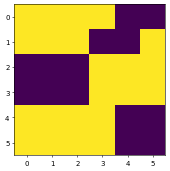

In [22]:
env.render()

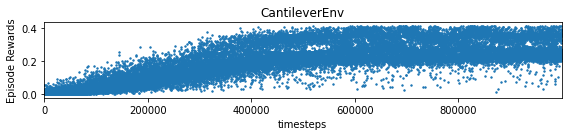

In [23]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [24]:
obs=env.reset()

In [25]:
# Load the agent
model_best = PPO.load(log_dir + "best_model.zip",env=env)

In [26]:
i=0
while i<1000:
    action, _states = model_best.predict(obs)
    
    obs, rewards, dones, info = env.step(int(action))
    if dones:
        break
    i+=1

In [27]:
i

36


Final Cantilever beam design:


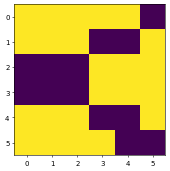

In [28]:
env.render()

In [29]:
# TODO - https://www.sciencedirect.com/science/article/pii/S0264127522002933

# 6 by 6 grid
# randomize loads 
# different reward 3 
# training ~1.5 hr
# forcing agent generalize better by limiting density more
# add force into input to generalize better 

# illegal moves reward = -1, terminate ? 

# CNN
# utilize symmetry
# reward at the end of episode
# action - remove elements not add 
# refinement 6x6 -> 12x12
# load two elements in inference - test generalizability
# input stress field instead of density field 
# test different RL algorithms 